In [90]:
from pandas_plink import read_plink1_bin
import pandas as pd
import numpy as np
import xarray as xr

In [91]:
sample_mapping_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/sample_mapping_file.tsv"
sample_mapping = pd.read_csv(sample_mapping_file, sep='\t', dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [92]:
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()

In [93]:
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [00:37<00:00, 12.58s/it]


In [94]:
G

<xarray.DataArray 'genotype' (sample: 1610, variant: 10464962)>
dask.array<transpose, shape=(1610, 10464962), dtype=float64, chunksize=(1024, 1024)>
Coordinates:
  * sample   (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
  * variant  (variant) object '13_13_19020917_G_A' ... '16_16_90274351_C_T'
    fid      (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) <U17 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
    father   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 -9.0 -9.0
    chrom    (variant) <U2 '13' '13' '13' '13' '13' ... '16' '16' '16' '16' '16'
    snp      (variant) <U16 '13_19020917_G_A' ... '16_90274351_C_T'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int64 19020917 19024664 19024785 ... 90193902 90274351
    a0       (variant) <U1 'G' 'T' 'A' 'G' 'T' 'A' ... 'G' 'C' 'T' 'G' 'C' 'C'
    a1       (variant) <U1 'A' 'C' 'G' 'A' 'C' 'G' ... 'T' 'T' 'G' 'T' 'T' 'T'

In [95]:
donors = sorted(set(list(G.sample.values)).intersection(donors))
len(donors)

125

In [96]:
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]

In [97]:
phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.feather"
phenotype = pd.read_feather(phenotype_file)
phenotype = phenotype.rename(columns={"index": "trait"}).set_index("trait")

In [98]:
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)

In [99]:
E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/mofa_logcounts_model_factors.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)

In [100]:
####

In [101]:
# eqtl_file = pd.read_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/interaction_test/MOFA/10mofa_factors_endo_eqtl/summary_endo_eqtl.csv", index_col=0)
eqtl_file = pd.read_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/interaction_test/10MOFA_fdr_1pct_results.csv")

In [102]:
eqtl_file.head()

,gene,n_snps,pv_raw,snpID,pv,qv
0,ENSG00000197019_SERTAD1,1,0.008098,19_40840936_G_T,0.008098,0.009999
1,ENSG00000160294_MCM3AP,2,0.004017,21_47592990_C_T,0.008034,0.009924
2,ENSG00000137275_RIPK1,1,0.008033,6_3057126_A_C,0.008033,0.009924
3,ENSG00000135537_LACE1,1,0.007998,6_108853493_A_G,0.007998,0.009887
4,ENSG00000256269_HMBS,2,0.003969,11_118957357_G_A,0.007938,0.009817


In [103]:
i=2
gene_name = eqtl_file['gene'][i]
snp_id = eqtl_file['snpID'][i]
gene_name

'ENSG00000137275_RIPK1'

In [104]:
y = phenotype.sel(trait=gene_name)
y

<xarray.DataArray (cell: 35751)>
array([1.92666767, 0.        , 0.        , ..., 2.09792115, 0.        ,
       0.        ])
Coordinates:
    trait    <U21 'ENSG00000137275_RIPK1'
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '24539_8#98'

In [105]:
G = G.sel(sample=sample_mapping["genotype_individual_id"].values)
g = G[:,G['snp']==snp_id]
ok = np.var(g.values, axis=0) > 0.0
g[:,ok]

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 2542 times more chunks
  return self.array[key]


<xarray.DataArray 'genotype' (sample: 35751, variant: 1)>
dask.array<getitem, shape=(35751, 1), dtype=float64, chunksize=(13471, 1)>
Coordinates:
  * sample   (sample) object 'HPSI0114i-joxm_1' ... 'HPSI1113i-wahn_1'
  * variant  (variant) object '6_6_3057126_A_C'
    fid      (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) <U17 'HPSI0114i-joxm_1' ... 'HPSI1113i-wahn_1'
    father   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 -9.0 -9.0
    chrom    (variant) <U2 '6'
    snp      (variant) <U16 '6_3057126_A_C'
    cm       (variant) float64 0.0
    pos      (variant) int64 3057126
    a0       (variant) <U1 'A'
    a1       (variant) <U1 'C'

In [106]:
len(g[:,ok].values)

35751

In [107]:
len(y.values)

35751

In [108]:
d = {snp_id: g[:,ok].values.tolist(), gene_name: y.values}
df = pd.DataFrame(data=d)
df.head()

,6_3057126_A_C,ENSG00000137275_RIPK1
0,[2.0],1.926668
1,[2.0],0.000000
2,[2.0],0.000000
3,[2.0],1.524537
4,[2.0],0.000000


In [109]:
df.columns = ['Genotype','Expression']
df['Genotype'] =[y for x in df['Genotype'] for y in x]
df.head()

,Genotype,Expression
0,2.0,1.926668
1,2.0,0.000000
2,2.0,0.000000
3,2.0,1.524537
4,2.0,0.000000


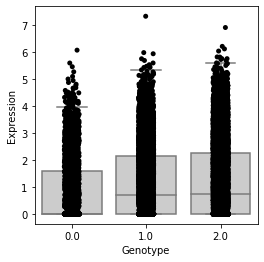

In [110]:
import seaborn as sns
from matplotlib.pyplot import *
fig = figure(figsize=(4,4))
ax = sns.boxplot(data=df, x='Genotype', y='Expression', color='.8', fliersize=False)
ax = sns.stripplot(x="Genotype", y="Expression", data=df, jitter=True, color='k')

In [111]:
df.columns = [snp_id, gene_name]
df.head()

,6_3057126_A_C,ENSG00000137275_RIPK1
0,2.0,1.926668
1,2.0,0.000000
2,2.0,0.000000
3,2.0,1.524537
4,2.0,0.000000


In [112]:
df.index = y.cell.values
df.head()

,6_3057126_A_C,ENSG00000137275_RIPK1
21843_1#10,2.0,1.926668
21843_1#100,2.0,0.000000
21843_1#101,2.0,0.000000
21843_1#102,2.0,1.524537
21843_1#103,2.0,0.000000


In [113]:
df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/interaction_test/MOFA/10factors_example_1.csv")